In [29]:
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [30]:
#viz function
def show(tensor, ch=1,size=(28,28), num=16):
  # tensor: 128(batch) x 784 => (128x1x28x28)
  data= tensor.detach().cpu().view(-1,ch,*size)
  grid = make_grid(data[:num],nrow=4).permute(1,2,0) #16x1x28x28=>28x28x1 # matplotlib (wid,high, ch)
  plt.imshow(grid)
  plt.show()

In [31]:
# setup of the main parameters and hyperparameters
epochs = 500
cur_step = 0
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss() #<-"Logiits" means a sigmoid modified output from 0 to 1. more numerically stable

bs = 128
device = 'cuda'

dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()),shuffle=True, batch_size=bs) # ToTensor()

# number of steps = 60000 / 128 = 468.75

In [32]:
from torch.nn.modules.batchnorm import BatchNorm3d
# declare our models

# Generator
def genBlock(inp, output):
  return nn.Sequential(
      nn.Linear(inp,output),
      nn.BatchNorm1d(output), #normalized value, stable training
      nn.ReLU(inplace=True) # non-linear function Learning complex stuff, inplace=true modify input directly without allocating extra resources.
  )

class Generator(nn.Module):
  def __init__(self, z_dim=64, i_dim=784, h_dim=128):
    super().__init__()
    self.gen = nn.Sequential(
        genBlock(z_dim, h_dim), # 64, 128
        genBlock(h_dim, h_dim*2), # 128, 256
        genBlock(h_dim*2, h_dim*4), # 256 x 512
        genBlock(h_dim*4, h_dim*8), # 512, 1024
        nn.Linear(h_dim*8, i_dim), # 1024, 784 (28x28)
        nn.Sigmoid(), # set the value btw 0 and 1
    )

  def forward(self, noise):
    return self.gen(noise)

def gen_noise(number, z_dim):
  return torch.randn(number, z_dim).to(device)

## Discriminator
def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim=784, h_dim=256):
    super().__init__()
    self.disc=nn.Sequential(
        discBlock(i_dim, h_dim*4), # 784, 1024
        discBlock(h_dim*4, h_dim*2), # 1024, 512
        discBlock(h_dim*2, h_dim), # 512, 256
        nn.Linear(h_dim, 1) # 256, 1
    )

  def forward(self, image):
      return self.disc(image)


In [33]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [34]:
gen #(1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) | affine <= learnable param | track_running_stats <= calcuate mean & std

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [35]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([1, 5, 5, 2, 2, 8, 4, 3, 6, 0])


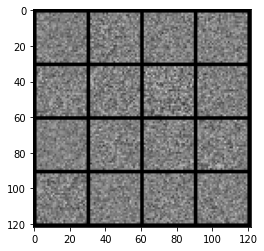

In [36]:
# iterator
x,y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)

In [37]:
# calculating the loss

# generator loss
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
   noise = gen_noise(number, z_dim)
   fake = gen(noise)
   pred = disc(fake)
   targets=torch.ones_like(pred)
   gen_loss=loss_func(pred,targets)

   return gen_loss


def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
   noise = gen_noise(number, z_dim)
   fake = gen(noise)
   disc_fake = disc(fake.detach())
   disc_fake_targets=torch.zeros_like(disc_fake)
   disc_fake_loss=loss_func(disc_fake, disc_fake_targets)

   disc_real = disc(real)
   disc_real_targets=torch.ones_like(disc_real)
   disc_real_loss=loss_func(disc_real, disc_real_targets)

   disc_loss=(disc_fake_loss+disc_real_loss)/2

   return disc_loss

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


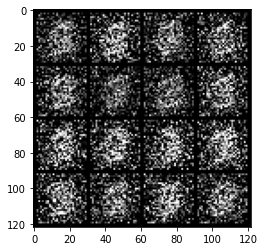

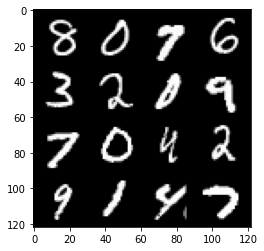

0: step 8400 / Gen loss: 0.8803358978033063 / disc_loss: 0.6541789173427968


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


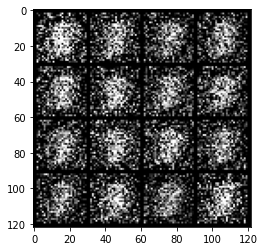

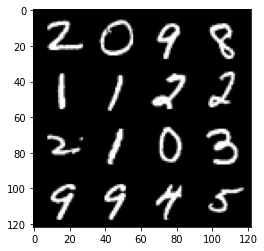

1: step 8700 / Gen loss: 0.8615786492824556 / disc_loss: 0.649905278881391


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


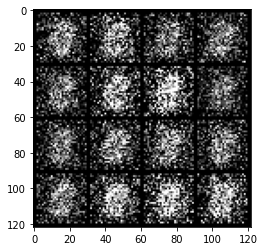

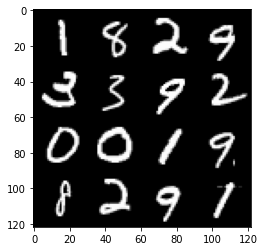

1: step 9000 / Gen loss: 0.9278181749582292 / disc_loss: 0.6424644428491593


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


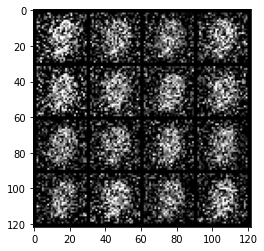

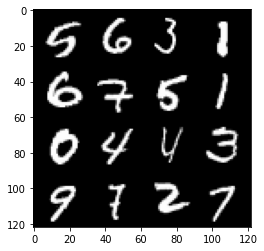

2: step 9300 / Gen loss: 0.9492032907406489 / disc_loss: 0.6274812698364254


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


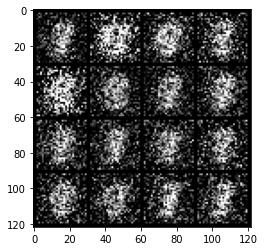

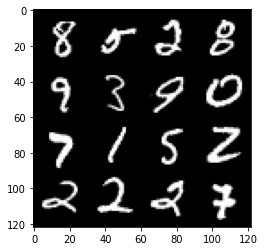

3: step 9600 / Gen loss: 1.015701377590497 / disc_loss: 0.5962350839376448


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


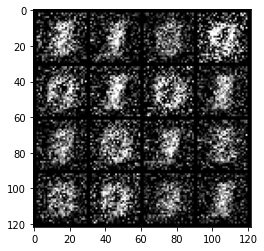

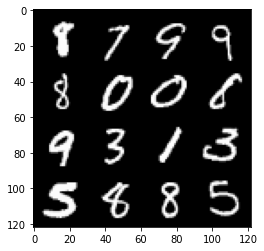

3: step 9900 / Gen loss: 1.080862034956614 / disc_loss: 0.5721790804465612


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


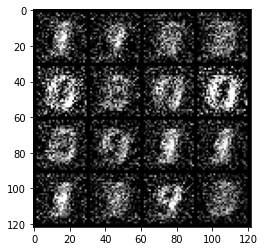

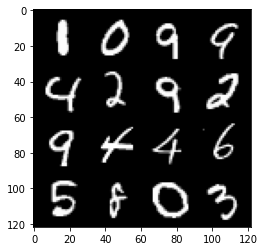

4: step 10200 / Gen loss: 1.083590058088303 / disc_loss: 0.5690549103418989


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


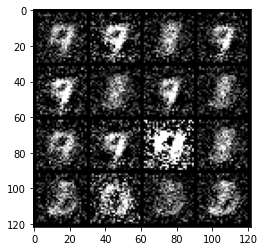

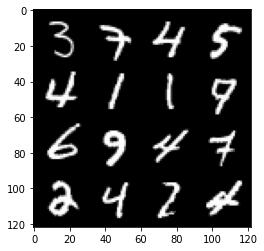

5: step 10500 / Gen loss: 1.0604452814658483 / disc_loss: 0.5880092006921767


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


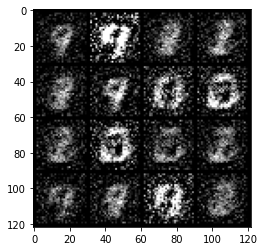

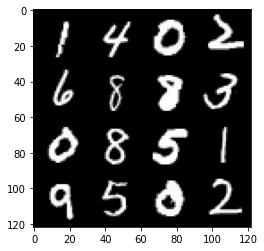

5: step 10800 / Gen loss: 0.9119950056076049 / disc_loss: 0.6364082737763723


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


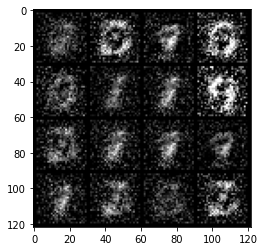

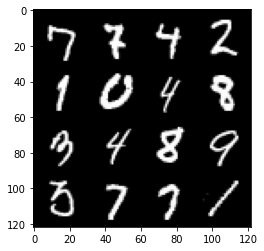

6: step 11100 / Gen loss: 0.7475078298648201 / disc_loss: 0.6829939617713293


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


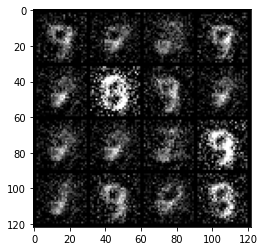

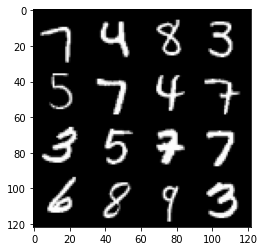

7: step 11400 / Gen loss: 0.6352671547730766 / disc_loss: 0.7033478554089856


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


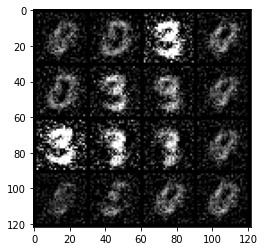

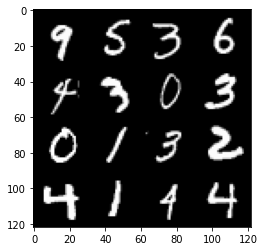

7: step 11700 / Gen loss: 0.5944923698902133 / disc_loss: 0.7028276673952734


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


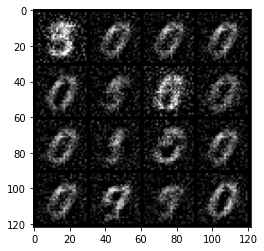

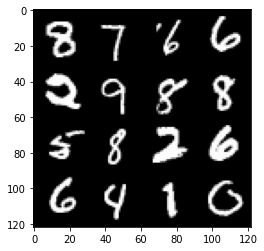

8: step 12000 / Gen loss: 0.6020212338368099 / disc_loss: 0.7052411502599719


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


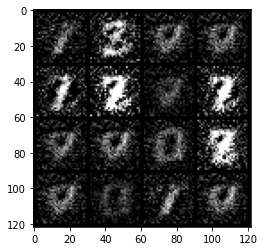

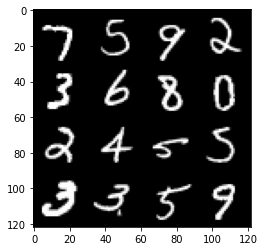

8: step 12300 / Gen loss: 0.6484081731239956 / disc_loss: 0.6825721480449045


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


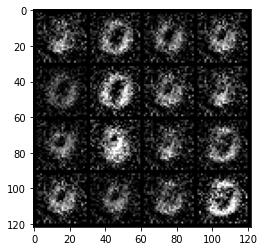

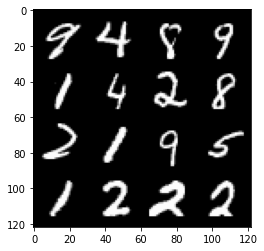

9: step 12600 / Gen loss: 0.6804698401689526 / disc_loss: 0.6873328421513242


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


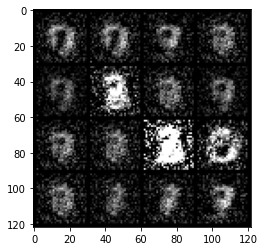

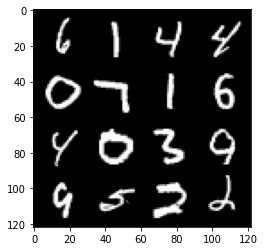

10: step 12900 / Gen loss: 0.7304638550678887 / disc_loss: 0.6745556968450546


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


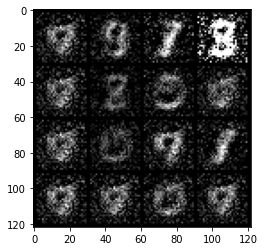

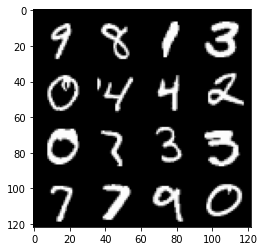

10: step 13200 / Gen loss: 0.7653774821758268 / disc_loss: 0.6672740429639813


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


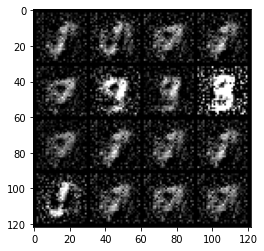

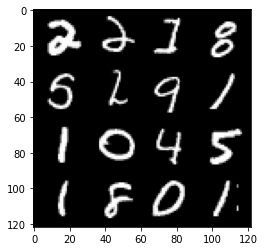

11: step 13500 / Gen loss: 0.7591314735015238 / disc_loss: 0.6670070304473242


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


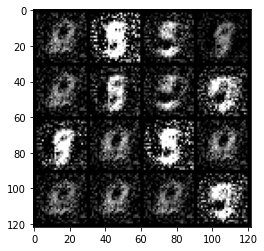

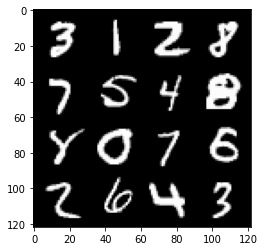

12: step 13800 / Gen loss: 0.7667141815026605 / disc_loss: 0.671805984179179


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


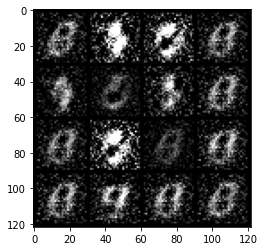

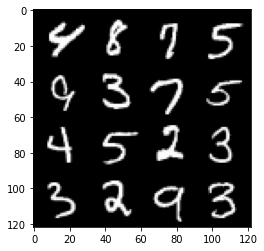

12: step 14100 / Gen loss: 0.7747259775797527 / disc_loss: 0.6705544139941529


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


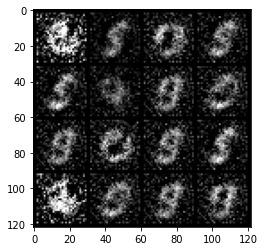

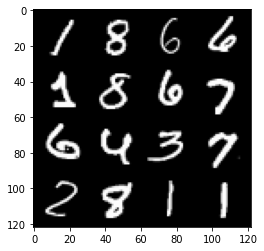

13: step 14400 / Gen loss: 0.7871956374247864 / disc_loss: 0.6573884904384616


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


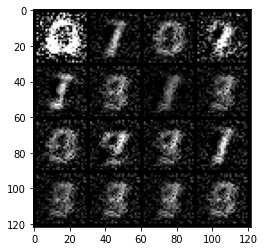

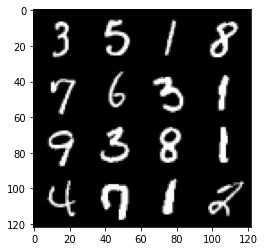

14: step 14700 / Gen loss: 0.7571454109748205 / disc_loss: 0.6750438419977823


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


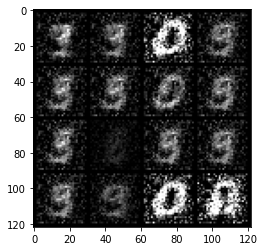

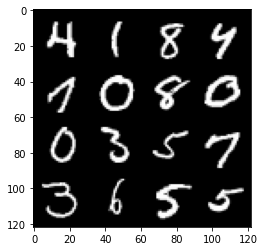

14: step 15000 / Gen loss: 0.7371312326192854 / disc_loss: 0.6848398178815841


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


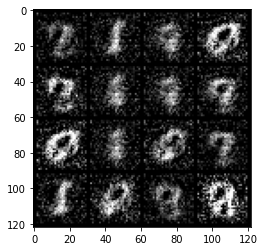

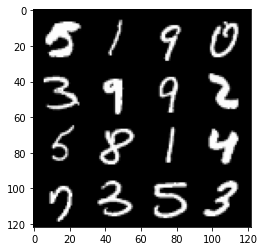

15: step 15300 / Gen loss: 0.7372806257009504 / disc_loss: 0.6817169602711999


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


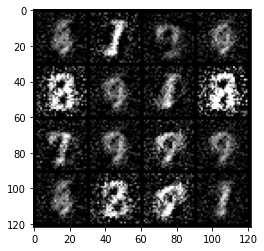

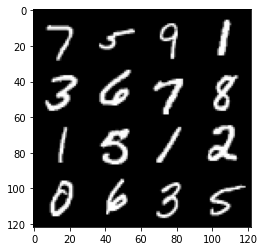

15: step 15600 / Gen loss: 0.7118973690271377 / disc_loss: 0.6806347171465559


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


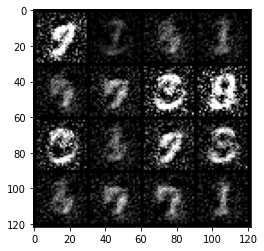

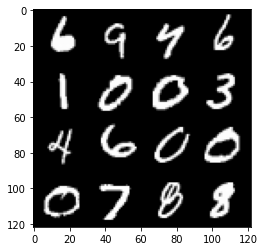

16: step 15900 / Gen loss: 0.7264461247126265 / disc_loss: 0.6715934850772227


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


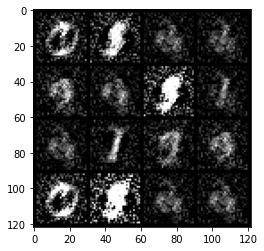

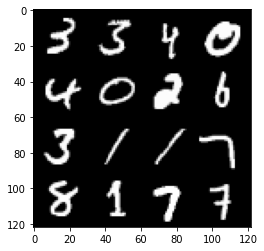

17: step 16200 / Gen loss: 0.7528725657860439 / disc_loss: 0.6612435402472818


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


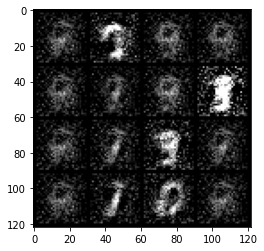

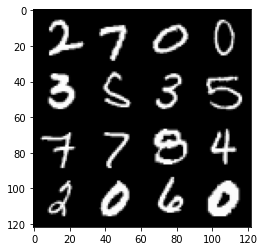

17: step 16500 / Gen loss: 0.8027577209472652 / disc_loss: 0.6432585893074673


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


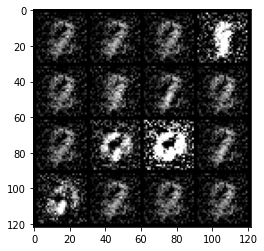

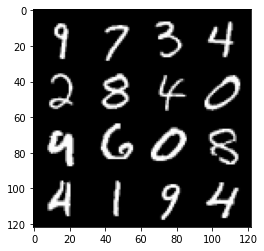

18: step 16800 / Gen loss: 0.8592554527521128 / disc_loss: 0.6463778322935102


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


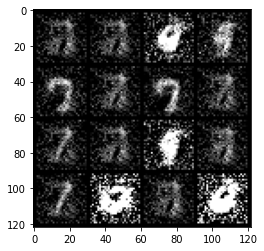

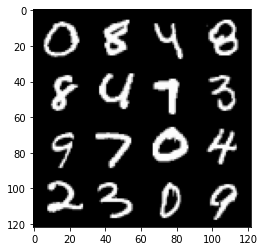

19: step 17100 / Gen loss: 0.885096295078595 / disc_loss: 0.6187159357468288


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


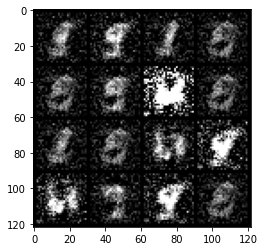

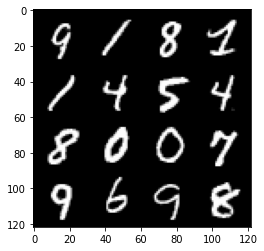

19: step 17400 / Gen loss: 0.8829654826720555 / disc_loss: 0.6305363990863159


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


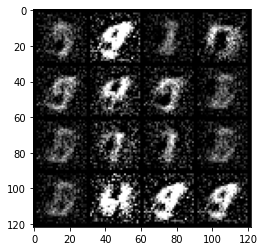

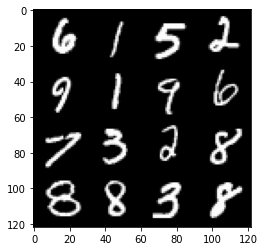

20: step 17700 / Gen loss: 0.8861408702532448 / disc_loss: 0.6228875869512555


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


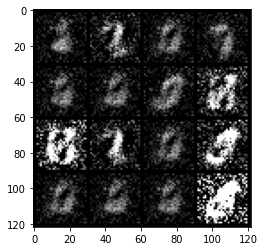

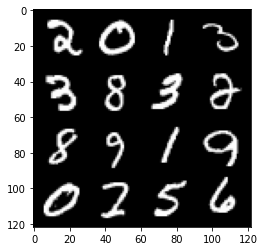

21: step 18000 / Gen loss: 0.8738053192694989 / disc_loss: 0.6291622209548953


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


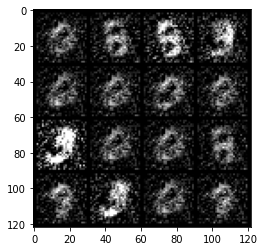

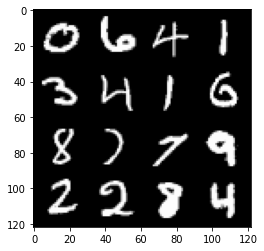

21: step 18300 / Gen loss: 0.8761818544069927 / disc_loss: 0.6268983397881189


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


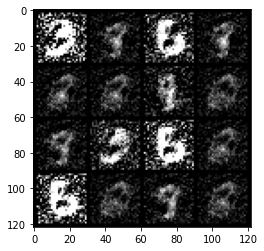

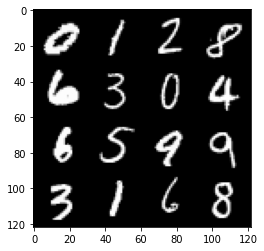

22: step 18600 / Gen loss: 0.9316507754723233 / disc_loss: 0.6037925853331884


KeyboardInterrupt: ignored

In [28]:
### 60000 / 128 = 468.75  = 469 steps in each epoch
### Each step is going to process 128 images = size of the batch (except the last step)

for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ### discriminator
    disc_opt.zero_grad()

    cur_bs=len(real) # real: 128 x 1 x 28 x 28
    real = real.view(cur_bs, -1) # 128 x 784
    real = real.to(device)

    disc_loss = calc_disc_loss(loss_func,gen,disc,cur_bs,real,z_dim)
    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    ### generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func,gen,disc,cur_bs,z_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()

    ### visualization & stats
    mean_disc_loss+=disc_loss.item()/info_step
    mean_gen_loss+=gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step>0:
      fake_noise = gen_noise(cur_bs, z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss=0,0
    cur_step+=1